The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install ..  # installing d2l


# Model Selection, Underfitting and Overfitting

:label:`sec_model_selection`


As machine learning scientists, our goal is to discover general patterns.
Say, for example, that we wish to learn the pattern
that associates genetic markers with the development of dementia in adulthood.
It is easy enough to memorize our training set.
Each person's genes uniquely identify them,
not just among people represented in our dataset,
but among all people on earth!

Given the genetic markers representing some person,
we do not want our model to simply recognize "oh, that is Bob",
and then output the classification,
say among {*dementia*, *mild cognitive impairment*, *healthy*},
that corresponds to Bob.
Rather, our goal is to discover patterns
that capture regularities in the underlying population
from which our training set was drawn.
If we are successfully in this endeavor,
then we could successfully assess risk
even for individuals that we have never encountered before.
This problem---how to discover patterns that *generalize*---is
the fundamental problem of machine learning.


The danger is that when we train models,
we access just a small sample of data.
The largest public image datasets contain roughly one million images.
And more often we have to learn from thousands or tens of thousands.
In a large hospital system we might access
hundreds of thousands of medical records.
With finite samples, we always run the risk
that we might discover *apparent* associations
that turn out not to hold up when we collect more data.

Let’s consider an extreme pathological case.
Imagine that you want to learn to predict
which people will repay their loans.
A lender hires you as a data scientist to investigate,
handing over the complete files on 100 applicants,
5 of which defaulted on their loans within 3 years.
Realistically, the files might include hundreds of potential features, including income, occupation, credit score, length of employment etc.
Moreover, say that they additionally hand over video footage
of each applicant's interview with their lending agent.

Now suppose that after featurizing the data into an enormous design matrix,
you discover that of the 5 applicants who default,
all of them were wearing blue shirts during their interviews,
while only 40% of general population wore blue shirts.
There is a good chance that if you train a predictive model
to predict default, it might rely upon blue-shirt-wearing
as an important feature.

Even if in fact defaulters were no more likely to wear blue shirts
than people in the general population,
there’s a $.4^5 = .01$ probability that
we would observe all five defaulters wearing blue shirts.
With just $5$ positive examples of defaults
and hundreds or thousands of features,
we would probably find a large number of features
that appear to be perfectly predictive of our labor
just due to random chance.
With an unlimited amount of data, we would expect
these *spurious* associations to eventually disappear.
But we seldom have that luxury.

The phenomena of fitting our training data
more closely than we fit the underlying distribution is called overfitting, and the techniques used to combat overfitting are called regularization.
In the previous sections, you might have observed
this effect while experimenting with the Fashion-MNIST dataset.
If you altered the model structure or the hyper-parameters during the experiment, you might have noticed that with enough nodes, layers, and training epochs, the model can eventually reach perfect accuracy on the training set, even as the accuracy on test data deteriorates.


## Training Error and Generalization Error

In order to discuss this phenomenon more formally,
we need to differentiate between *training error* and *generalization error*.
The training error is the error of our model
as calculated on the training dataset,
while generalization error is the expectation of our model's error
were we to apply it to an infinite stream of additional data points
drawn from the same underlying data distribution as our original sample.

Problematically, *we can never calculate the generalization error exactly*.
That is because the imaginary stream of infinite data is an imaginary object.
In practice, we must *estimate* the generalization error
by applying our model to an independent test set
constituted of a random selection of data points
that were withheld from our training set.

The following three thought experiments
will help illustrate this situation better.
Consider a college student trying to prepare for his final exam.
A diligent student will strive to practice well
and test her abilities using exams from previous years.
Nonetheless, doing well on past exams is no guarantee
that she will excel when it matters.
For instance, the student might try to prepare
by rote learning the answers to the exam questions.
This requires the student to memorize many things.
She might even remember the answers for past exams perfectly.
Another student might prepare by trying to understand
the reasons for giving certain answers.
In most cases, the latter student will do much better.

Likewise, consider a model that simply uses a lookup table to answer questions. If the set of allowable inputs is discrete and reasonably small, then perhaps after viewing *many* training examples, this approach would perform well. Still this model has no ability to do better than random guessing when faced with examples that it has never seen before.
In reality the input spaces are far too large to memorize the answers corresponding to every conceivable input. For example, consider the black and white $28\times28$ images. If each pixel can take one among $256$ gray scale values, then there are $256^{784}$ possible images. That means that there are far more low-res grayscale thumbnail-sized images than there are atoms in the universe. Even if we could encounter this data, we could never afford to store the lookup table.

Last, consider the problem of trying
to classify the outcomes of coin tosses (class 0: heads, class 1: tails)
based on some contextual features that might be available.
No matter what algorithm we come up with,
because the generalization error will always be $\frac{1}{2}$.
However, for most algorithms,
we should expect our training error to be considerably lower,
depending on the luck of the draw,
even if we did not have any features!
Consider the dataset {0, 1, 1, 1, 0, 1}.
Our feature-less would have to fall back on always predicting
the *majority class*, which appears from our limited sample to be *1*.
In this case, the model that always predicts class 1
will incur an error of $\frac{1}{3}$,
considerably better than our generalization error.
As we increase the amount of data,
the probability that the fraction of heads
will deviate significantly from $\frac{1}{2}$ diminishes,
and our training error would come to match the generalization error.


### Statistical Learning Theory

Since generalization is the fundamental problem in machine learning,
you might not be surprised to learn
that many mathematicians and theorists have dedicated their lives
to developing formal theories to describe this phenomenon.
In their [eponymous theorem](https://en.wikipedia.org/wiki/Glivenko%E2%80%93Cantelli_theorem), Glivenko and Cantelli
derived the rate at which the training error
converges to the generalization error.
In a series of seminal papers, [Vapnik and Chervonenkis](https://en.wikipedia.org/wiki/Vapnik%E2%80%93Chervonenkis_theory)
extended this theory to more general classes of functions.
This work laid the foundations of [Statistical Learning Theory](https://en.wikipedia.org/wiki/Statistical_learning_theory).


In the *standard supervised learning setting*, which we have addressed up until now and will stick throughout most of this book,
we assume that both the training data and the test data
are drawn *independently* from *identical* distributions
(commonly called the i.i.d. assumption).
This means that the process that samples our data has no *memory*.
The $2^{\mathrm{nd}}$ example drawn and the $3^{\mathrm{rd}}$ drawn
are no more correlated than the $2^{\mathrm{nd}}$ and the $2$-millionth sample drawn.

Being a good machine learning scientist requires thinking critically,
and already you should be poking holes in this assumption,
coming up with common cases where the assumption fails.
What if we train a mortality risk predictor
on data collected from patients at UCSF,
and apply it on patients at Massachusetts General Hospital?
These distributions are simply not identical.
Moreover, draws might be correlated in time.
What if we are classifying the topics of Tweets.
The news cycle would create temporal dependencies
in the topics being discussed violating any assumptions of independence.

Sometimes we can get away with minor violations of the i.i.d. assumption
and our models will continue to work remarkably well.
After all, nearly every real-world application
involves at least some minor violation of the i.i.d. assumption,
and yet we have useful tools for face recognition,
speech recognition, language translation, etc.

Other violations are sure to cause trouble.
Imagine, for example, if we tried to train
a face recognition system by training it
exclusively on university students
and then want to deploy it as a tool
for monitoring geriatrics in a nursing home population.
This is unlikely to work well since college students
tend to look considerably different from the elderly.

In subsequent chapters and volumes, we will discuss problems
arising from violations of the i.i.d. assumption.
For now, even taking the i.i.d. assumption for granted,
understanding generalization is a formidable problem.
Moreover, elucidating the precise theoretical foundations
that might explain why deep neural networks generalize as well as they do
continues to vexes the greatest minds in learning theory.

When we train our models, we attempt searching for a function
that fits the training data as well as possible.
If the function is so flexible that it can catch on to spurious patterns
just as easily as to the true associations,
then it might perform *too well* without producing a model
that generalizes well to unseen data.
This is precisely what we want to avoid (or at least control).
Many of the techniques in deep learning are heuristics and tricks
aimed at guarding against overfitting.

### Model Complexity

When we have simple models and abundant data,
we expect the generalization error to resemble the training error.
When we work with more complex models and fewer examples,
we expect the training error to go down but the generalization gap to grow.
What precisely constitutes model complexity is a complex matter.
Many factors govern whether a model will generalize well.
For example a model with more parameters might be considered more complex.
A model whose parameters can take a wider range of values
might be more complex.
Often with neural networks, we think of a model
that takes more training steps as more complex,
and one subject to *early stopping* as less complex.

It can be difficult to compare the complexity among members
of substantially different model classes
(say a decision tree versus a neural network).
For now, a simple rule of thumb is quite useful:
A model that can readily explain arbitrary facts
is what statisticians view as complex,
whereas one that has only a limited expressive power
but still manages to explain the data well
is probably closer to the truth.
In philosophy, this is closely related to Popper’s
criterion of [falsifiability](https://en.wikipedia.org/wiki/Falsifiability)
of a scientific theory: a theory is good if it fits data
and if there are specific tests which can be used to disprove it.
This is important since all statistical estimation is
[post hoc](https://en.wikipedia.org/wiki/Post_hoc),
i.e., we estimate after we observe the facts,
hence vulnerable to the associated fallacy.
For now, we will put the philosophy aside and stick to more tangible issues.

In this section, to give you some intuition,
we’ll focus on a few factors that tend
to influence the generalizability of a model class:

1. The number of tunable parameters. When the number of tunable parameters, sometimes called the *degrees of freedom*, is large, models tend to be more susceptible to overfitting.
1. The values taken by the parameters. When weights can take a wider range of values, models can be more susceptible to over fitting.
1. The number of training examples. It’s trivially easy to overfit a dataset containing only one or two examples even if your model is simple. But overfitting a dataset with millions of examples requires an extremely flexible model.


## Model Selection

In machine learning, we usually select our final model
after evaluating several candidate models.
This process is called model selection.
Sometimes the models subject to comparison
are fundamentally different in nature
(say, decision trees vs linear models).
At other times, we are comparing
members of the same class of models
that have been trained with different hyperparameter settings.

With multilayer perceptrons for example,
we may wish to compare models with
different numbers of hidden layers,
different numbers of hidden units,
and various choices of the activation functions
applied to each hidden layer.
In order to determine the best among our candidate models,
we will typically employ a validation set.


### Validation Dataset

In principle we should not touch our test set
until after we have chosen all our hyper-parameters.
Were we to use the test data in the model selection process,
there is a risk that we might overfit the test data.
Then we would be in serious trouble.
If we overfit our training data,
there is always the evaluation on test data to keep us honest.
But if we overfit the test data, how would we ever know?


Thus, we should never rely on the test data for model selection.
And yet we cannot rely solely on the training data
for model selection either because
we cannot estimate the generalization error
on the very data that we use to train the model.

The common practice to address this problem
is to split our data three ways,
incorporating a *validation set*
in addition to the training and test sets.


In practical applications, the picture gets muddier.
While ideally we would only touch the test data once,
to assess the very best model or to compare
a small number of models to each other,
real-world test data is seldom discarded after just one use.
We can seldom afford a new test set for each round of experiments.

The result is a murky practice where the boundaries
between validation and test data are worryingly ambiguous.
Unless explicitly stated otherwise, in the experiments in this book
we are really working with what should rightly be called
training data and validation data, with no true test sets.
Therefore, the accuracy reported in each experiment
is really the validation accuracy and not a true test set accuracy.
The good news is that we do not need too much data in the validation set.
The uncertainty in our estimates can be shown
to be of the order of $\mathcal{O}(n^{-\frac{1}{2}})$.


### $K$-Fold Cross-Validation

When training data is scarce,
we might not even be able to afford to hold out
enough data to constitute a proper validation set.
One popular solution to this problem is to employ
$K$*-fold cross-validation*.
Here, the original training data is split into $K$ non-overlapping subsets.
Then model training and validation are executed $K$ times,
each time training on $K-1$ subsets and validating
on a different subset (the one not used for training in that round).
Finally, the training and validation error rates are estimated
by averaging over the results from the $K$ experiments.


## Underfitting or Overfitting?

When we compare the training and validation errors,
we want to be mindful of two common situations:
First, we want to watch out for cases
when our training error and validation error are both substantial
but there is a little gap between them.
If the model is unable to reduce the training error,
that could mean that our model is too simple
(i.e., insufficiently expressive)
to capture the pattern that we are trying to model.
Moreover, since the *generalization gap*
between our training and validation errors is small,
we have reason to believe that we could get away with a more complex model.
This phenomenon is known as underfitting.

On the other hand, as we discussed above,
we want to watch out for the cases
when our training error is significantly lower
than our validation error, indicating severe overfitting.
Note that overfitting is not always a bad thing.
With deep learning especially, it is well known
that the best predictive models often perform
far better on training data than on holdout data.
Ultimately, we usually care more about the validation error
than about the gap between the training and validation errors.

Whether we overfit or underfit can depend
both on the complexity of our model
and the size of the available training datasets,
two topics that we discuss below.

### Model Complexity

To illustrate some classical intuition
about overfitting and model complexity,
we given an example using polynomials.
Given training data consisting of a single feature $x$
and a corresponding real-valued label $y$,
we try to find the polynomial of degree $d$

$$\hat{y}= \sum_{i=0}^d x^i w_i$$

to estimate the labels $y$.
This is just a linear regression problem
where our features are given by the powers of $x$,
the $w_i$ given the model’s weights,
and the bias is given by $w_0$ since $x^0 = 1$ for all $x$.
Since this is just a linear regression problem,
we can use the squared error as our loss function.


A higher-order polynomial function is more complex
than a lower order polynomial function,
since the higher-order polynomial has more parameters
and the model function’s selection range is wider.
Fixing the training dataset,
higher-order polynomial functions should always
achieve lower (at worst, equal) training error
relative to lower degree polynomials.
In fact, whenever the data points each have a distinct value of $x$,
a polynomial function with degree equal to the number of data points
can fit the training set perfectly.
We visualize the relationship between polynomial degree
and under- vs over-fitting in :numref:`fig_capacity_vs_error`.

![Influence of Model Complexity on Underfitting and Overfitting](http://d2l.ai/_images/capacity_vs_error.svg)

:label:`fig_capacity_vs_error`


### Dataset Size

The other big consideration to bear in mind is the dataset size.
Fixing our model, the fewer samples we have in the training dataset,
the more likely (and more severely) we are to encounter overfitting.
As we increase the amount of training data,
the generalization error typically decreases.
Moreover, in general, more data never hurts.
For a fixed task and data *distribution*,
there is typically a relationship between model complexity and dataset size.
Given more data, we might profitably attempt to fit a more complex model.
Absent sufficient data, simpler models may be difficult to beat.
For many tasks, deep learning only outperforms linear models
when many thousands of training examples are available.
In part, the current success of deep learning
owes to the current abundance of massive datasets
due to internet companies, cheap storage, connected devices,
and the broad digitization of the economy.

## Polynomial Regression

We can now explore these concepts interactively
by fitting polynomials to data.
To get started we will import our usual packages.

In [1]:
import d2l
from mxnet import gluon, np, npx
from mxnet.gluon import nn
npx.set_np()

### Generating the Dataset

First we need data. Given $x$, we will use the following cubic polynomial to generate the labels on training and test data:

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1).$$

The noise term $\epsilon$ obeys a normal distribution
with a mean of 0 and a standard deviation of 0.1.
We will synthesize 100 samples each for the training set and test set.

In [2]:
maxdegree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(maxdegree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
features = np.random.shuffle(features)
poly_features = np.power(features, np.arange(maxdegree).reshape(1, -1))
poly_features = poly_features / (
    npx.gamma(np.arange(maxdegree) + 1).reshape(1, -1))
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

For optimization, we typically want to avoid
very large values of gradients, losses, etc.
This is why the monomials stored in `poly_features`
are rescaled from $x^i$ to $\frac{1}{i!} x^i$.
It allows us to avoid very large values for large exponents $i$.
Factorials are implemented in Gluon using the Gamma function,
where $n! = \Gamma(n+1)$.

Take a look at the first 2 samples from the generated dataset.
The value 1 is technically a feature,
namely the constant feature corresponding to the bias.

In [3]:
features[:2], poly_features[:2], labels[:2]

(array([[-0.03716067],
        [-1.1468065 ]]),
 array([[ 1.00000000e+00, -3.71606685e-02,  6.90457586e-04,
         -8.55262169e-06,  7.94552903e-08, -5.90522298e-10,
          3.65736781e-12, -1.94157468e-14,  9.01877669e-17,
         -3.72381952e-19,  1.38379622e-21, -4.67479880e-24,
          1.44765544e-26, -4.13814215e-29,  1.09840096e-31,
         -2.72115417e-34,  6.31999553e-37, -1.38150092e-39,
          2.85164237e-42, -5.60519386e-45],
        [ 1.00000000e+00, -1.14680648e+00,  6.57582462e-01,
         -2.51373291e-01,  7.20691308e-02, -1.65298693e-02,
          3.15942708e-03, -5.17607376e-04,  7.41994299e-05,
         -9.45470947e-06,  1.08427218e-06, -1.13040933e-07,
          1.08030065e-08, -9.52996793e-10,  7.80644993e-11,
         -5.96832479e-12,  4.27782159e-13, -2.88578399e-14,
          1.83857564e-15, -1.10973155e-16]]),
 array([ 5.1432443 , -0.06415092]))

### Training and Testing Model

Let's first implement a function to evaluate the loss on a given data.

In [4]:
# Saved in the d2l package for later use
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset"""
    metric = d2l.Accumulator(2)  # sum_loss, num_examples
    for X, y in data_iter:
        metric.add(loss(net(X), y).sum(), y.size)
    return metric[0] / metric[1]

Now define the training function.

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=1000):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch % 50 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss),
                                 evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

### Third-Order Polynomial Function Fitting (Normal)

We will begin by first using a third-order polynomial function
with the same order as the data generation function.
The results show that this model’s training error rate
when using the testing dataset is low.
The trained model parameters are also close
to the true values $w = [5, 1.2, -3.4, 5.6]$.

weight: [[ 5.015801   1.195607  -3.4175324  5.6197805]]


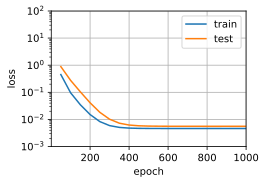

In [6]:
# Pick the first four dimensions, i.e., 1, x, x^2, x^3 from the polynomial
# features
train(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4],
      labels[:n_train], labels[n_train:])

### Linear Function Fitting (Underfitting)

Let’s take another look at linear function fitting.
After the decline in the early epoch,
it becomes difficult to further decrease
this model’s training error rate.
After the last epoch iteration has been completed,
the training error rate is still high.
When used to fit non-linear patterns
(like the third-order polynomial function here)
linear models are liable to underfit.

weight: [[ 5.264786   4.0222955 -3.9895918]]


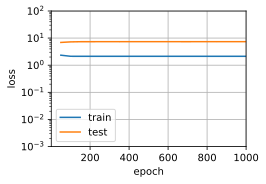

In [7]:
# Pick the first four dimensions, i.e., 1, x from the polynomial features
train(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3],
      labels[:n_train], labels[n_train:])

### Insufficient Training (Overfitting)

Now let's try to train the model
using a polynomial of too high degree.
Here, there is insufficient data to learn that
the higher-degree coefficients should have values close to zero.
As a result, our overly-complex model
is far too susceptible to being influenced
by noise in the training data.
Of course, our training error will now be low
(even lower than if we had the right model!)
but our test error will be high.

Try out different model complexities (`n_degree`)
and training set sizes (`n_subset`)
to gain some intuition of what is happening.

weight: [[ 4.9480042   1.3321037  -3.209672    5.043265   -0.42166913  1.3474398
   0.07512859  0.19178352 -0.01918835  0.01772064 -0.0509516  -0.02382804
  -0.01497367 -0.04940014  0.06389725 -0.04761839 -0.04380196 -0.05188226
   0.05655775  0.01104914]]


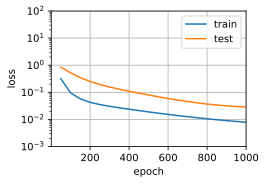

In [8]:
n_subset = 100  # Subset of data to train on
n_degree = 20  # Degree of polynomials
train(poly_features[1:n_subset, 0:n_degree],
      poly_features[n_train:, 0:n_degree], labels[1:n_subset],
      labels[n_train:])

In later chapters, we will continue
to discuss overfitting problems
and methods for dealing with them,
such as weight decay and dropout.


## Summary

* Since the generalization error rate cannot be estimated based on the training error rate, simply minimizing the training error rate will not necessarily mean a reduction in the generalization error rate. Machine learning models need to be careful to safeguard against overfitting such as to minimize the generalization error.
* A validation set can be used for model selection (provided that it is not used too liberally).
* Underfitting means that the model is not able to reduce the training error rate while overfitting is a result of the model training error rate being much lower than the testing dataset rate.
* We should choose an appropriately complex model and avoid using insufficient training samples.


## Exercises

1. Can you solve the polynomial regression problem exactly? Hint: use linear algebra.
1. Model selection for polynomials
    * Plot the training error vs. model complexity (degree of the polynomial). What do you observe?
    * Plot the test error in this case.
    * Generate the same graph as a function of the amount of data?
1. What happens if you drop the normalization of the polynomial features $x^i$ by $1/i!$. Can you fix this in some other way?
1. What degree of polynomial do you need to reduce the training error to 0?
1. Can you ever expect to see 0 generalization error?

## [Discussions](https://discuss.mxnet.io/t/2341)

![](../img/qr_underfit-overfit.svg)